# Explore here

Step 1: Load and Explore Data


In [12]:
# Your code here
import pandas as pd
import pickle
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
# Load data
url = "https://raw.githubusercontent.com/4GeeksAcademy/naive-bayes-project-tutorial/main/playstore_reviews.csv"
df = pd.read_csv(url)

# Show first 5 rows
df.head()

,package_name,review,polarity
0,com.facebook.katana,privacy at least put some option appear offli...,0
1,com.facebook.katana,"messenger issues ever since the last update, ...",0
2,com.facebook.katana,profile any time my wife or anybody has more ...,0
3,com.facebook.katana,the new features suck for those of us who don...,0
4,com.facebook.katana,forced reload on uploading pic on replying co...,0


Step 2: Preprocess Text Data

/tmp/ipykernel_3642/2012286940.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='polarity', data=df, palette='viridis')


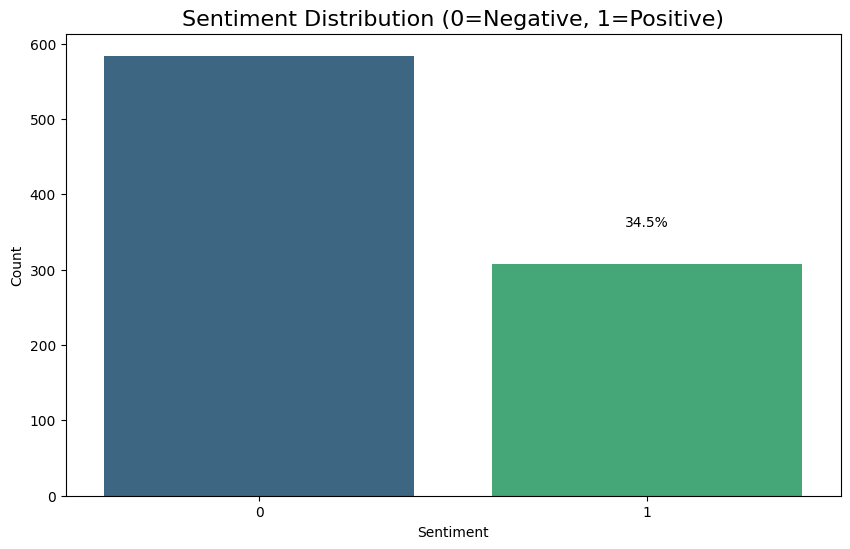

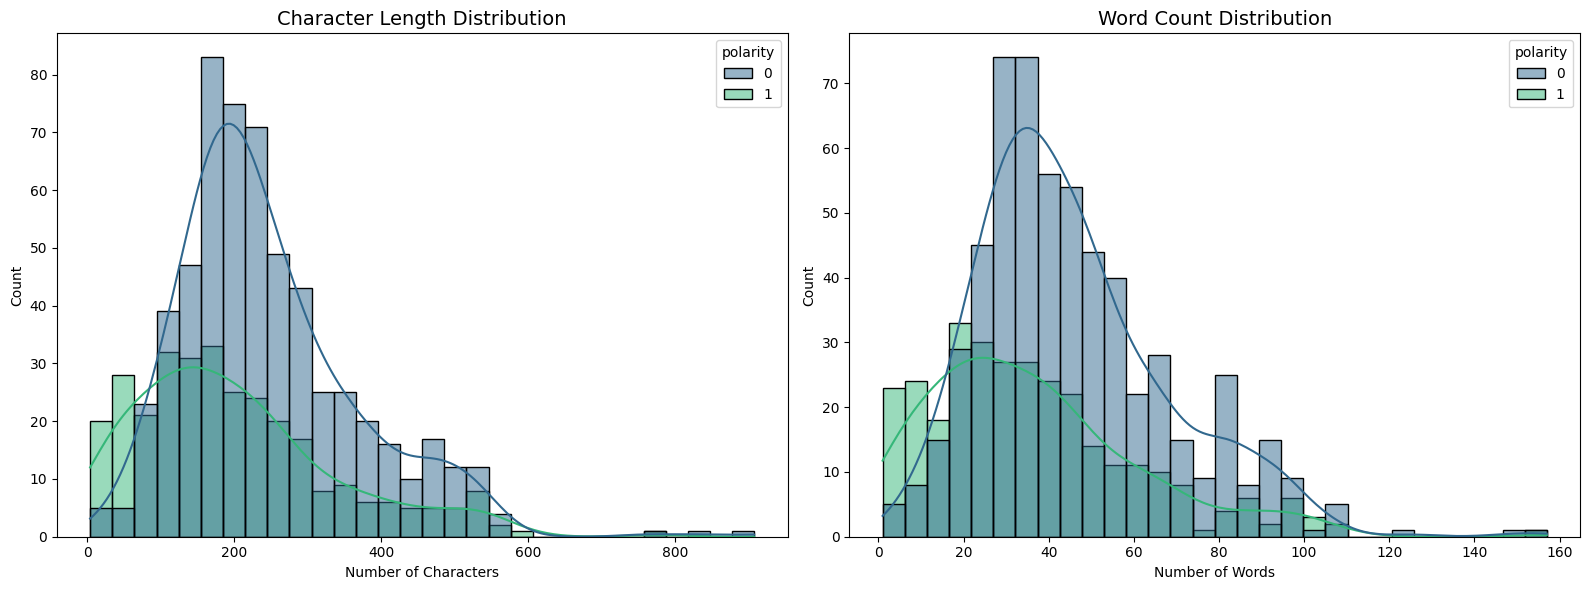

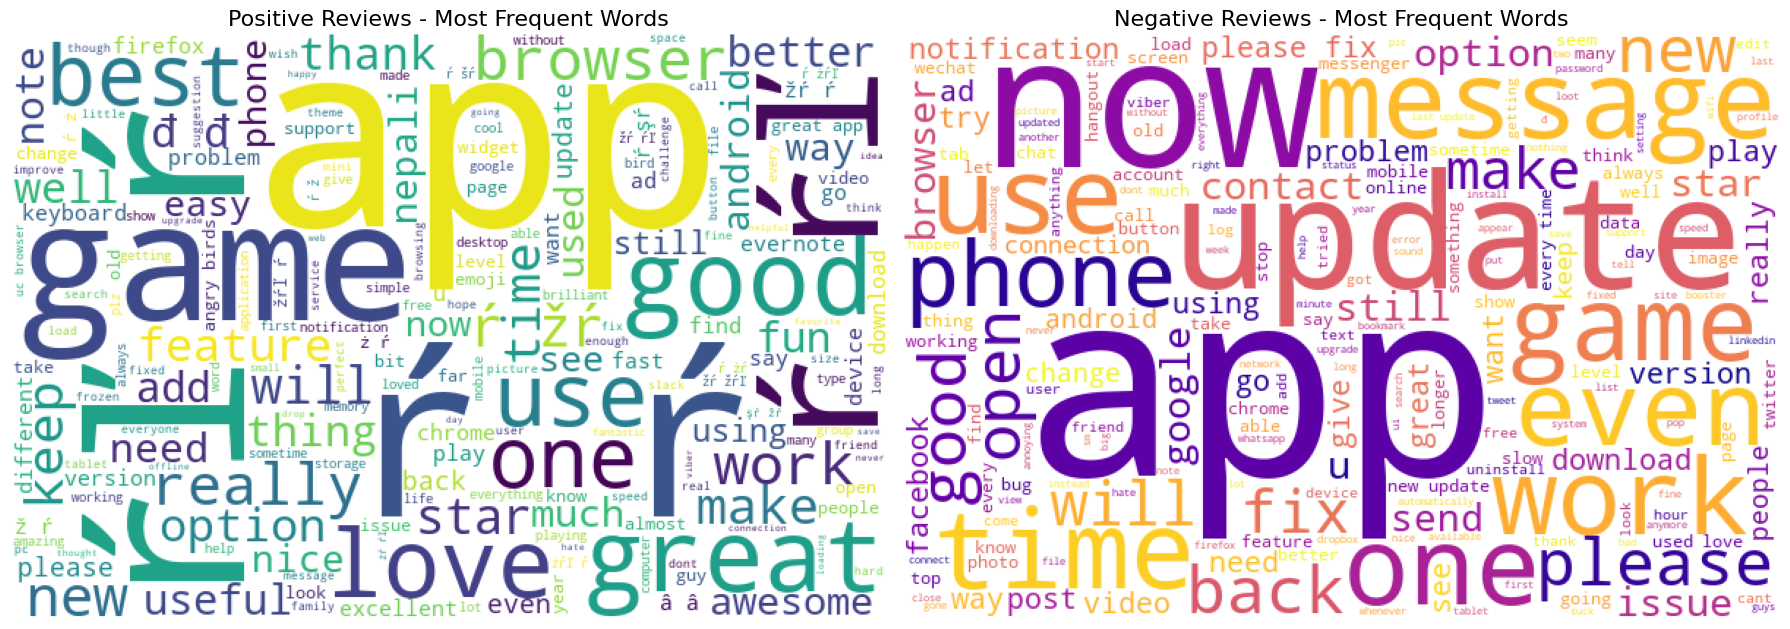

KeyError: 'package_name'

<Figure size 1200x800 with 0 Axes>

In [13]:
# Remove irrelevant column
df = df.drop(columns=['package_name'])

# Clean text: lowercase + remove extra spaces
df['review'] = df['review'].str.strip().str.lower()

# Sentiment distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='polarity', data=df, palette='viridis')
plt.title('Sentiment Distribution (0=Negative, 1=Positive)', fontsize=16)
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Add percentages
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    x = p.get_x() + p.get_width()/2
    y = p.get_height() + 50
    ax.annotate(percentage, (x, y), ha='center', fontsize=10)
plt.show()

# Review length analysis
df['review_length'] = df['review'].apply(len)
df['word_count'] = df['review'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df, x='review_length', hue='polarity', bins=30, 
             kde=True, palette='viridis', ax=axes[0])
axes[0].set_title('Character Length Distribution', fontsize=14)
axes[0].set_xlabel('Number of Characters')

sns.histplot(df, x='word_count', hue='polarity', bins=30, 
             kde=True, palette='viridis', ax=axes[1])
axes[1].set_title('Word Count Distribution', fontsize=14)
axes[1].set_xlabel('Number of Words')
plt.tight_layout()
plt.show()

# Word clouds
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
positive_text = " ".join(df[df['polarity']==1]['review'])
negative_text = " ".join(df[df['polarity']==0]['review'])

positive_wc = WordCloud(width=600, height=400, background_color='white', 
                        colormap='viridis').generate(positive_text)
axes[0].imshow(positive_wc)
axes[0].set_title('Positive Reviews - Most Frequent Words', fontsize=16)
axes[0].axis('off')

negative_wc = WordCloud(width=600, height=400, background_color='white', 
                        colormap='plasma').generate(negative_text)
axes[1].imshow(negative_wc)
axes[1].set_title('Negative Reviews - Most Frequent Words', fontsize=16)
axes[1].axis('off')
plt.tight_layout()
plt.show()

# Top apps analysis
plt.figure(figsize=(12, 8))
top_apps = df['package_name'].value_counts().nlargest(10)
ax = sns.barplot(x=top_apps.values, y=top_apps.index, palette='viridis')
plt.title('Top 10 Most Reviewed Apps', fontsize=16)
plt.xlabel('Number of Reviews')
plt.ylabel('Application')

# Add sentiment distribution
for i, app in enumerate(top_apps.index):
    app_reviews = df[df['package_name']==app]
    pos_percent = 100 * app_reviews['polarity'].mean()
    ax.text(top_apps.values[i] + 20, i, 
            f'{pos_percent:.1f}% positive', 
            va='center', fontsize=10)
plt.show()

# Sentiment vs length analysis
plt.figure(figsize=(10, 6))
sns.boxplot(x='polarity', y='review_length', data=df, palette='viridis')
plt.title('Review Length vs. Sentiment', fontsize=16)
plt.xlabel('Sentiment (0=Negative, 1=Positive)')
plt.ylabel('Character Count')
plt.show()

# Correlation calculation
corr = df[['polarity', 'review_length']].corr().iloc[0,1]
print(f"Correlation between sentiment and review length: {corr:.4f}")

# Drop temporary columns before modeling
df = df.drop(columns=['review_length', 'word_count'])
# Split data
X = df['review']
y = df['polarity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Step 3: Convert Text to Numbers

In [7]:
# Create word-count matrix (ignore English stopwords like "the", "and")
vectorizer = CountVectorizer(stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

Step 4: Build & Compare Naive Bayes Models

In [8]:
# Initialize models
models = {
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "GaussianNB": GaussianNB()
}

# Train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

# Show results
pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])

,Accuracy
MultinomialNB,0.815642
BernoulliNB,0.770950
GaussianNB,0.804469


Step 5: Optimize the Best Model


In [9]:
# Tune MultinomialNB (best performer)
alphas = [0.1, 0.5, 1.0, 2.0]  # Smoothing parameters

for alpha in alphas:
    model = MultinomialNB(alpha=alpha)
    model.fit(X_train_vec, y_train)
    acc = model.score(X_test_vec, y_test)
    print(f"Alpha {alpha}: Accuracy = {acc:.4f}")

Alpha 0.1: Accuracy = 0.8324
Alpha 0.5: Accuracy = 0.8268
Alpha 1.0: Accuracy = 0.8156
Alpha 2.0: Accuracy = 0.8324


Step 6: Compare with Random Forest


In [10]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_vec, y_train)
rf_acc = rf.score(X_test_vec, y_test)

print(f"Random Forest Accuracy: {rf_acc:.4f}")
print(f"Best NB Accuracy: {max(results.values()):.4f}")

Random Forest Accuracy: 0.8045
Best NB Accuracy: 0.8156


Step 7: Save the Model


In [ ]:
# Save best model
best_model = MultinomialNB(alpha=0.5)
best_model.fit(X_train_vec, y_train)
pickle.dump(best_model, open('naive_bayes_model.pkl', 'wb'))

# Save vectorizer too (for new text preprocessing)
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))
